2025-01-12 13:57:37.236185: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-12 13:57:37.351605: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736686657.398135    3140 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736686657.411529    3140 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-12 13:57:37.521834: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

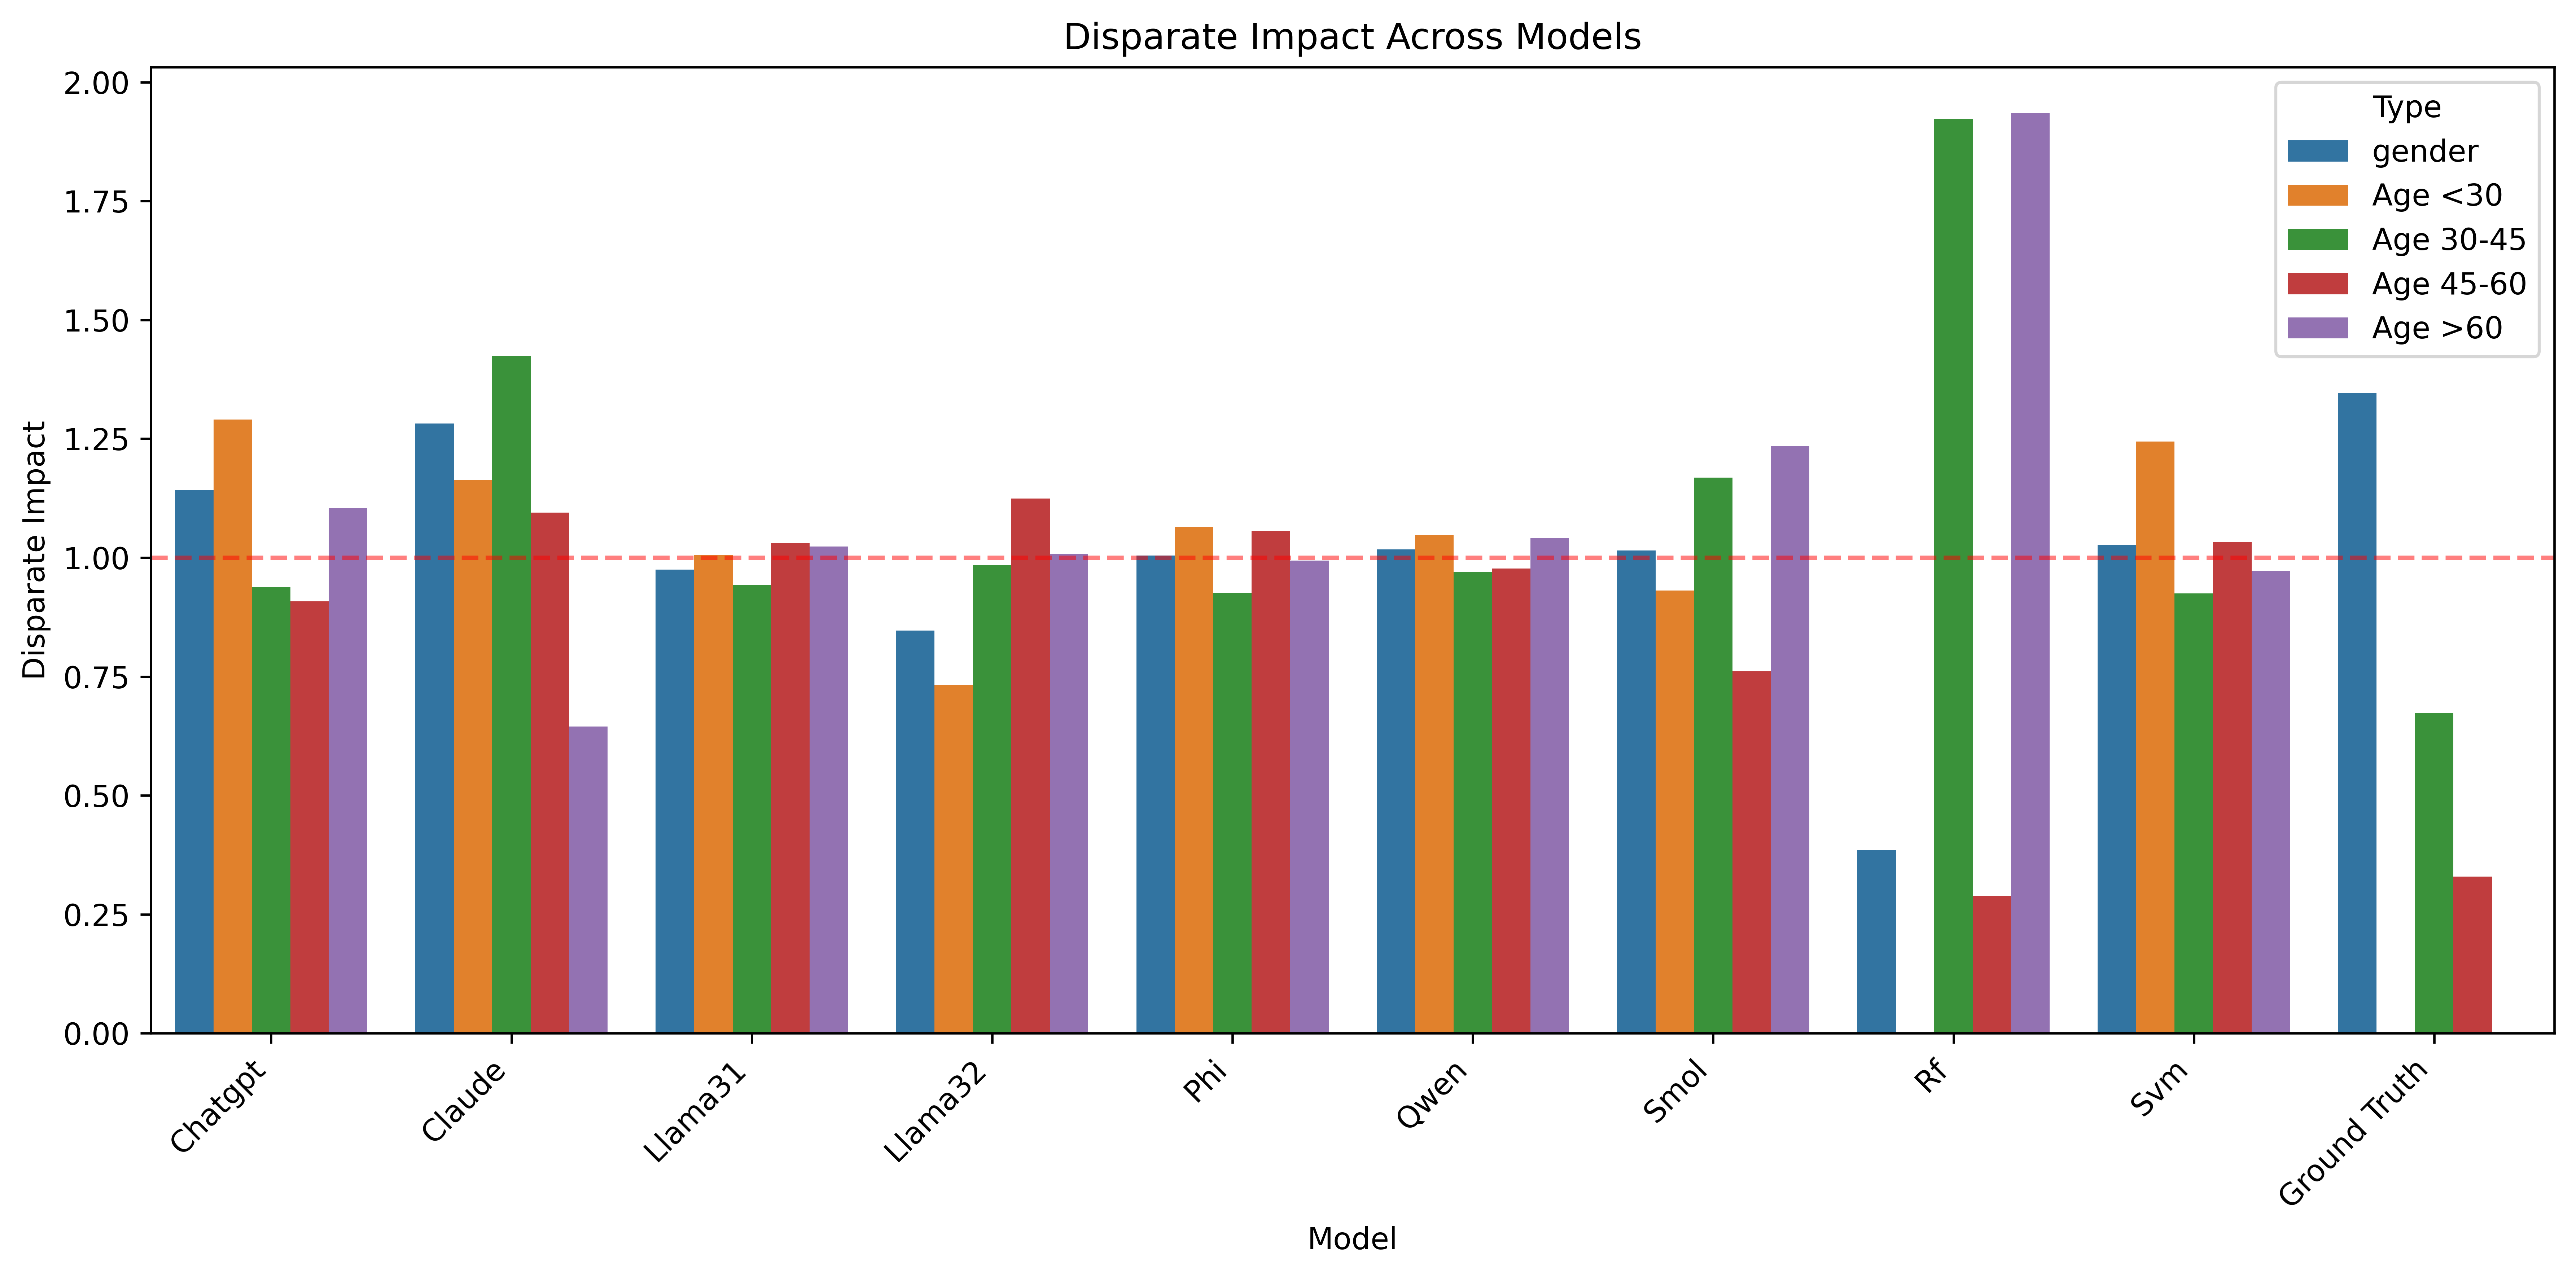

/tmp/ipykernel_3140/532158386.py:156: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


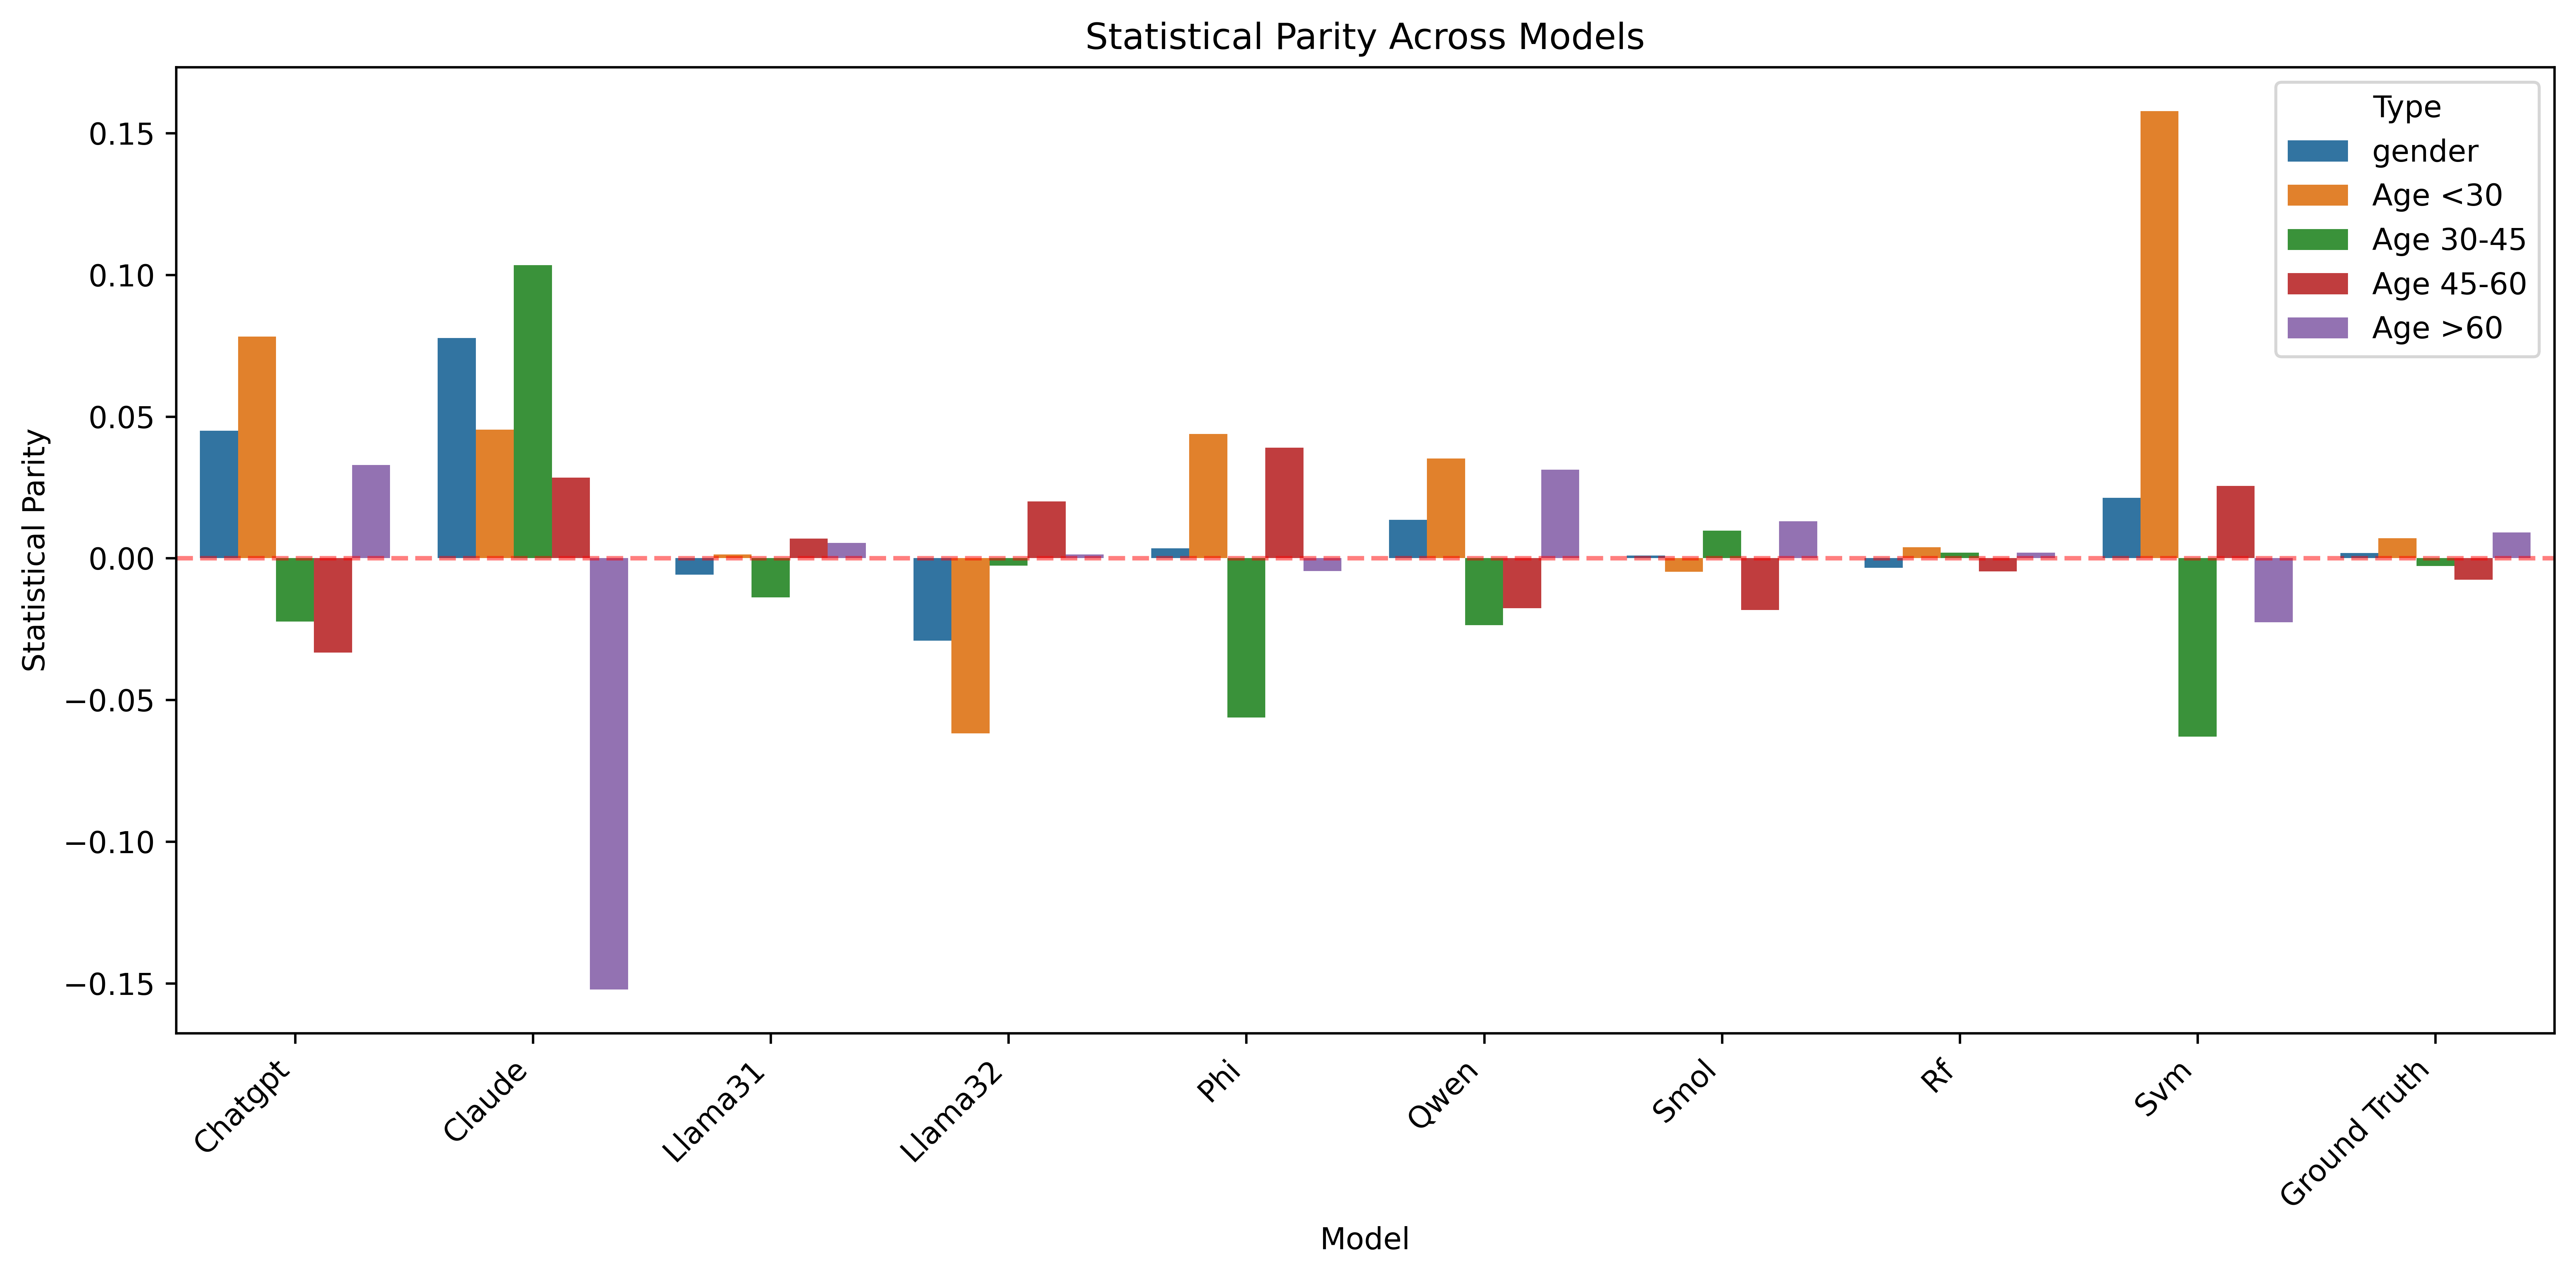


Summary Statistics:
           Model       Type  Disparate Impact  Statistical Parity
0        Chatgpt     gender          1.142552            0.045047
1        Chatgpt    Age <30          1.290780            0.078287
2        Chatgpt  Age 30-45          0.937510           -0.022346
3        Chatgpt  Age 45-60          0.908072           -0.033333
4        Chatgpt    Age >60          1.103756            0.032963
5         Claude     gender          1.282456            0.077666
6         Claude    Age <30          1.164124            0.045450
7         Claude  Age 30-45          1.423986            0.103500
8         Claude  Age 45-60          1.094595            0.028455
9         Claude    Age >60          0.644939           -0.152169
10       Llama31     gender          0.975263           -0.005820
11       Llama31    Age <30          1.005803            0.001339
12       Llama31  Age 30-45          0.942974           -0.013799
13       Llama31  Age 45-60          1.030220          

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric

# Load the data
df = pd.read_csv('/home/hessel/code/master-thesis/src/results/final/final_dataset.ssv', sep=";")

# Define model responses to analyze, now including metadata
model_responses = ['chatgpt_response', 'claude_response', 'llama31_response',
                  'llama32_response', 'phi_response', 'qwen_response', 'smol_response', 
                  'rf_response', 'svm_response', 'Metadata']  # Added Metadata

# Extract demographics from prompts
demographics = []
for prompt in df['Prompt']:
    if not isinstance(prompt, str):
        demographics.append((None, None))
        continue
        
    age_match = re.search(r'(\d+)-year-old', prompt)
    gender_match = re.search(r'-year-old\s+(\w+)', prompt)
    
    age = int(age_match.group(1)) if age_match else None
    gender = gender_match.group(1).lower() if gender_match else None
    
    gender_binary = 1.0 if gender == 'male' else 0.0 if gender == 'female' else None
    
    if age is not None:
        age_group = pd.cut([age], bins=[0, 30, 45, 60, float('inf')], 
                          labels=['<30', '30-45', '45-60', '>60'])[0]
    else:
        age_group = None
        
    demographics.append((gender_binary, age_group))

df['gender'], df['age_group'] = zip(*demographics)

# Create age group indicators
for group in ['<30', '30-45', '45-60', '>60']:
    df[f'age_{group}'] = (df['age_group'] == group).astype(float)

# Update ground truth extraction from metadata to handle the new format
df['ground_truth'] = df['Metadata'].apply(
    lambda x: 1.0 if isinstance(x, str) and "'fraud': True" in x else 0.0
)

# Extract model predictions, now including metadata
for model_col in model_responses:
    model_name = model_col.split('_')[0]
    prediction_col = f'{model_name}_prediction'
    
    if model_col == 'Metadata':
        df['metadata_prediction'] = df['Metadata'].apply(
            lambda x: 1.0 if isinstance(x, str) and "'fraud': True" in x else 0.0
        )
    else:
        df[prediction_col] = df[model_col].apply(
            lambda x: 1.0 if 'CONCLUSION: FRAUD' in str(x).upper() 
            else 0.0
        )

# Calculate bias metrics for each model
results = []
for model_col in model_responses:
    if model_col == 'Metadata':
        model_name = 'Ground Truth'
        prediction_col = 'metadata_prediction'
    else:
        model_name = model_col.split('_')[0].capitalize()
        prediction_col = f'{model_name.lower()}_prediction'
    
    if prediction_col not in df.columns:
        continue
        
    df_model = df.copy()
    df_model['label'] = df_model[prediction_col]
    
    # Analyze gender bias
    try:
        dataset = BinaryLabelDataset(
            df=df_model[['label', 'gender']].dropna(),
            label_names=['label'],
            protected_attribute_names=['gender'],
            privileged_protected_attributes=[[1.0]]
        )
        
        metrics = BinaryLabelDatasetMetric(
            dataset,
            unprivileged_groups=[{'gender': 0.0}],
            privileged_groups=[{'gender': 1.0}]
        )
        
        gender_metrics = {
            'disparate_impact': metrics.disparate_impact(),
            'statistical_parity': metrics.statistical_parity_difference()
        }
    except:
        gender_metrics = {'disparate_impact': np.nan, 'statistical_parity': np.nan}
    
    results.append({
        'Model': model_name,
        'Type': 'gender',
        'Disparate Impact': gender_metrics['disparate_impact'],
        'Statistical Parity': gender_metrics['statistical_parity']
    })
    
    # Analyze age group bias
    for group in ['<30', '30-45', '45-60', '>60']:
        try:
            dataset = BinaryLabelDataset(
                df=df_model[['label', f'age_{group}']].dropna(),
                label_names=['label'],
                protected_attribute_names=[f'age_{group}'],
                privileged_protected_attributes=[[1.0]]
            )
            
            metrics = BinaryLabelDatasetMetric(
                dataset,
                unprivileged_groups=[{f'age_{group}': 0.0}],
                privileged_groups=[{f'age_{group}': 1.0}]
            )
            
            age_metrics = {
                'disparate_impact': metrics.disparate_impact(),
                'statistical_parity': metrics.statistical_parity_difference()
            }
        except:
            age_metrics = {'disparate_impact': np.nan, 'statistical_parity': np.nan}
            
        results.append({
            'Model': model_name,
            'Type': f'Age {group}',
            'Disparate Impact': age_metrics['disparate_impact'],
            'Statistical Parity': age_metrics['statistical_parity']
        })

metrics_df = pd.DataFrame(results)

# Plot disparate impact
plt.figure(figsize=(12, 6), dpi=600)
ax = sns.barplot(data=metrics_df, x='Model', y='Disparate Impact', hue='Type')
ax.axhline(y=1, color='r', linestyle='--', alpha=0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title('Disparate Impact Across Models')
plt.tight_layout()
plt.show()

# Plot statistical parity
plt.figure(figsize=(12, 6), dpi=600)
ax = sns.barplot(data=metrics_df, x='Model', y='Statistical Parity', hue='Type')
ax.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title('Statistical Parity Across Models')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(metrics_df)

# Print prediction distribution for each model
print("\nPrediction Distribution by Model:")
for model_col in model_responses:
    if model_col == 'Metadata':
        print("\nGround Truth:")
        print(df['metadata_prediction'].value_counts(dropna=False))
    else:
        model_name = model_col.split('_')[0]
        pred_col = f'{model_name}_prediction'
        if pred_col in df.columns:
            print(f"\n{model_name}:")
            print(df[pred_col].value_counts(dropna=False))

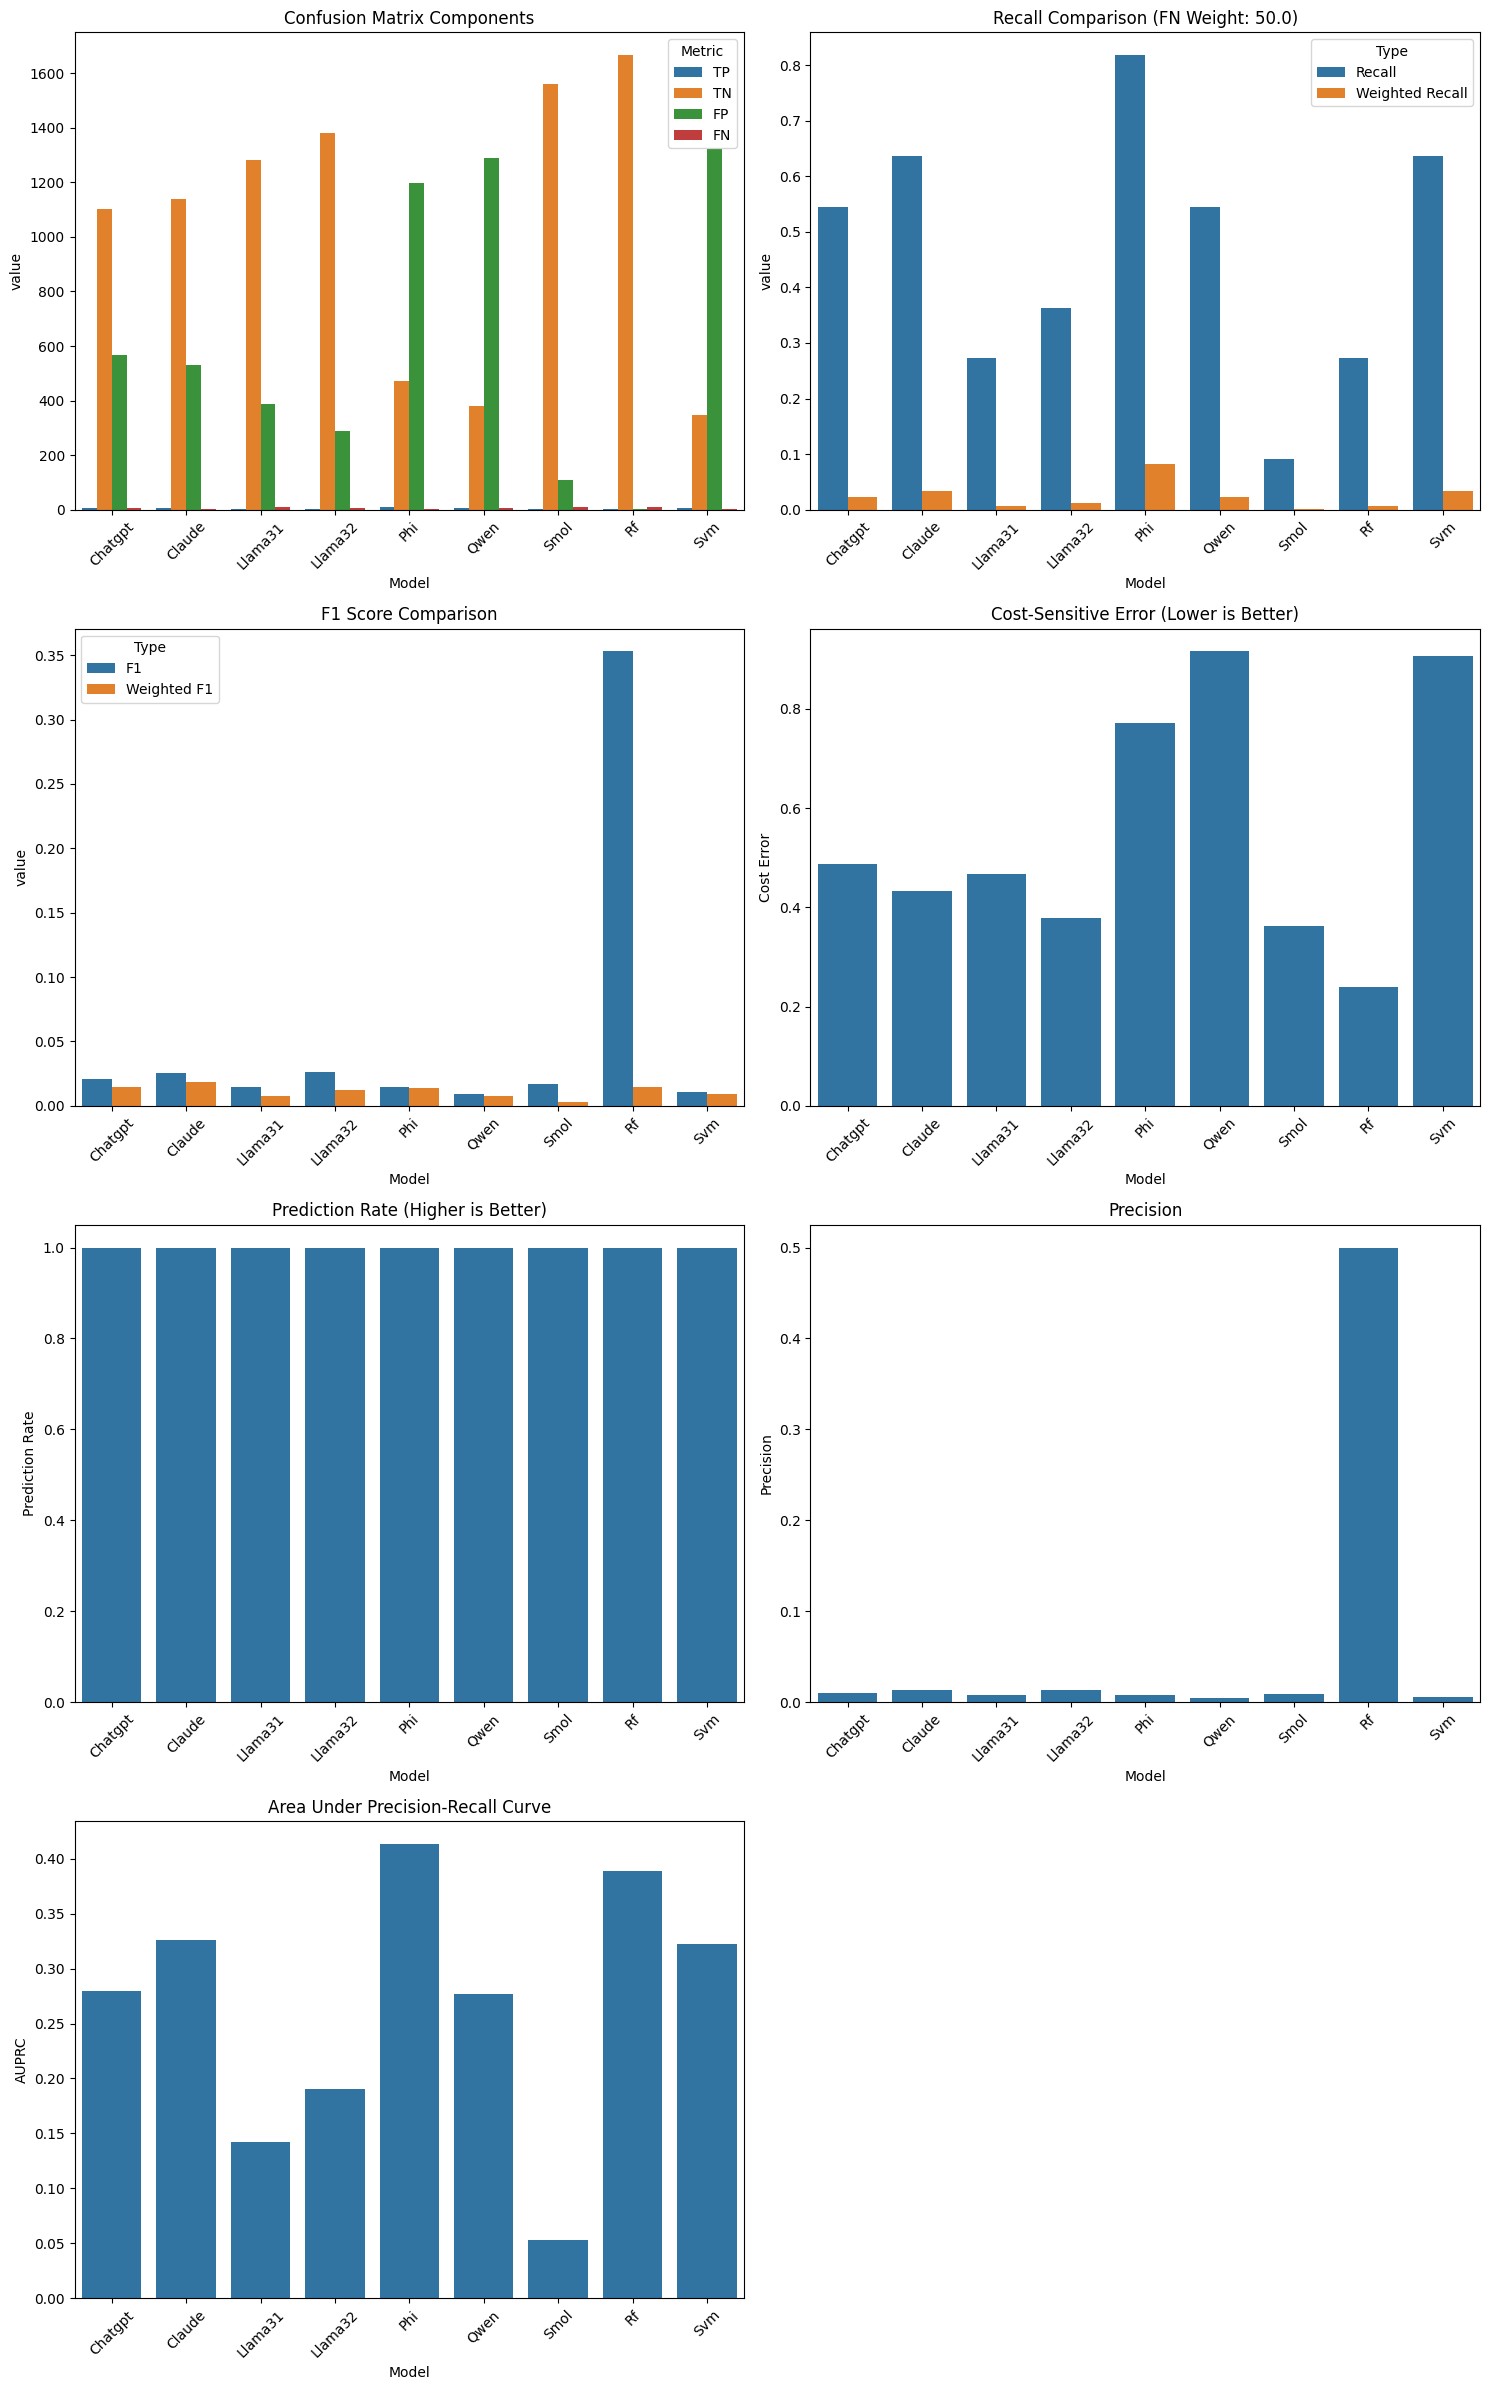

,Model,TP,TN,FP,FN,Precision,Recall,F1,AUPRC,Weighted Recall,Weighted F1,Cost Error,Prediction Rate
0,Chatgpt,6,1102,568,5,0.010453,0.545455,0.020513,0.279441,0.023438,0.014458,0.486615,1.0
1,Claude,7,1141,529,4,0.013060,0.636364,0.025594,0.325901,0.033816,0.018843,0.433670,1.0
2,Llama31,3,1283,387,8,0.007692,0.272727,0.014963,0.142589,0.007444,0.007566,0.468174,1.0
3,Llama32,4,1382,288,7,0.013699,0.363636,0.026403,0.190750,0.011299,0.012384,0.379536,1.0
4,Phi,9,473,1197,2,0.007463,0.818182,0.014790,0.413417,0.082569,0.013688,0.771565,1.0
5,Qwen,6,380,1290,5,0.004630,0.545455,0.009181,0.276529,0.023438,0.007732,0.916121,1.0
6,Smol,1,1562,108,10,0.009174,0.090909,0.016667,0.053016,0.001996,0.003279,0.361689,1.0
7,Rf,3,1667,3,8,0.500000,0.272727,0.352941,0.388743,0.007444,0.014670,0.239738,1.0
8,Svm,7,346,1324,4,0.005259,0.636364,0.010432,0.322001,0.033816,0.009103,0.906603,1.0


In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, precision_recall_curve, auc

def analyze_model_performance(df, fn_weight=10.0):
    """
    Analyze model performance with weighted penalties for false negatives.
    
    Args:
        df: DataFrame with model predictions and ground truth
        fn_weight: Penalty weight for false negatives (default: 10.0)
    Returns:
        DataFrame with performance metrics for each model
    """
    # Get list of prediction columns (format: modelname_prediction)
    model_cols = [col for col in df.columns if col.endswith('_prediction')]
    results = []
    
    for col in model_cols:
        model_name = col.split('_')[0].title()
        
        # Get valid predictions (not NaN) and ground truth
        valid_mask = df[['ground_truth', col]].notna().all(axis=1)
        y_true = df.loc[valid_mask, 'ground_truth']
        y_pred = df.loc[valid_mask, col]
        
        if len(y_pred) > 0:
            # Calculate metrics
            tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
            precision, recall, f1, _ = precision_recall_fscore_support(
                y_true, y_pred, average='binary', zero_division=0
            )
            
            # Calculate AUPRC
            precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_pred)
            auprc = auc(recall_curve, precision_curve)
            
            # Calculate weighted metrics
            weighted_recall = tp / (tp + fn_weight * fn) if (tp + fn_weight * fn) > 0 else 0
            weighted_f1 = (2 * precision * weighted_recall) / (precision + weighted_recall) \
                         if (precision + weighted_recall) > 0 else 0
            cost_error = (fp + fn_weight * fn) / len(y_pred)
            
            # Calculate prediction rate
            prediction_rate = len(y_pred) / len(df)
            
            results.append({
                'Model': model_name,
                'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn,
                'Precision': precision,
                'Recall': recall,
                'F1': f1,
                'AUPRC': auprc,
                'Weighted Recall': weighted_recall,
                'Weighted F1': weighted_f1,
                'Cost Error': cost_error,
                'Prediction Rate': prediction_rate
            })
    
    return pd.DataFrame(results)

def plot_metrics(df, fn_weight=50.0):
    """
    Plot performance metrics for all models.
    
    Args:
        df: DataFrame with model predictions
        fn_weight: False negative penalty weight
    """
    metrics_df = analyze_model_performance(df, fn_weight)
    
    fig, axes = plt.subplots(4, 2, figsize=(15, 24))  # Added one more row for AUPRC
    plt.style.use('default')  # Use default style instead of seaborn
    
    # Plot confusion matrix components
    confusion_data = pd.melt(
        metrics_df,
        id_vars=['Model'],
        value_vars=['TP', 'TN', 'FP', 'FN'],
        var_name='Metric'
    )
    sns.barplot(data=confusion_data, x='Model', y='value', hue='Metric', ax=axes[0,0])
    axes[0,0].set_title('Confusion Matrix Components')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Plot recall comparison
    recall_data = pd.melt(
        metrics_df,
        id_vars=['Model'],
        value_vars=['Recall', 'Weighted Recall'],
        var_name='Type'
    )
    sns.barplot(data=recall_data, x='Model', y='value', hue='Type', ax=axes[0,1])
    axes[0,1].set_title(f'Recall Comparison (FN Weight: {fn_weight})')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # Plot F1 comparison
    f1_data = pd.melt(
        metrics_df,
        id_vars=['Model'],
        value_vars=['F1', 'Weighted F1'],
        var_name='Type'
    )
    sns.barplot(data=f1_data, x='Model', y='value', hue='Type', ax=axes[1,0])
    axes[1,0].set_title('F1 Score Comparison')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # Plot cost error
    sns.barplot(data=metrics_df, x='Model', y='Cost Error', ax=axes[1,1])
    axes[1,1].set_title('Cost-Sensitive Error (Lower is Better)')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    # Plot prediction rate
    sns.barplot(data=metrics_df, x='Model', y='Prediction Rate', ax=axes[2,0])
    axes[2,0].set_title('Prediction Rate (Higher is Better)')
    axes[2,0].tick_params(axis='x', rotation=45)
    
    # Plot precision
    sns.barplot(data=metrics_df, x='Model', y='Precision', ax=axes[2,1])
    axes[2,1].set_title('Precision')
    axes[2,1].tick_params(axis='x', rotation=45)
    
    # Plot AUPRC
    sns.barplot(data=metrics_df, x='Model', y='AUPRC', ax=axes[3,0])
    axes[3,0].set_title('Area Under Precision-Recall Curve')
    axes[3,0].tick_params(axis='x', rotation=45)
    
    # Keep the last subplot empty or use it for another metric if needed
    axes[3,1].remove()
    
    plt.tight_layout()
    plt.show()
    
    return metrics_df

def run_performance_analysis(df, model_responses, fn_weight=50.0):
    """
    Run complete performance analysis pipeline.
    
    Args:
        df: Raw DataFrame with model responses
        model_responses: List of model response column names
        fn_weight: False negative penalty weight
    """
    # First process the predictions using functions from the previous code
    df = process_model_predictions(df, model_responses)
    
    # Then run performance analysis
    metrics_df = plot_metrics(df, fn_weight)
    
    # Display formatted metrics
    display(metrics_df.style
           .format({col: "{:.3f}" for col in metrics_df.columns if col != 'Model'})
           .background_gradient(subset=['Cost Error'], cmap='RdYlGn_r')
           .background_gradient(subset=['F1', 'Weighted F1', 'Prediction Rate', 'AUPRC'], cmap='RdYlGn'))
    
    return metrics_df

plot_metrics(df)

In [46]:
#df = metrics_df
df.head()

,Prompt,chatgpt_response,claude_response,llama31_response,llama32_response,qwen_response,phi_response,smol_response,rf_response,svm_response,...,ground_truth,chatgpt_prediction,claude_prediction,llama31_prediction,llama32_prediction,phi_prediction,qwen_prediction,smol_prediction,rf_prediction,svm_prediction
0,You are an expert fraud detection analyst with...,The transaction aligns with the customer's typ...,The transaction raises multiple red flags: cov...,[clear analysis in a single complete sentence]...,"Based on the context, customer profile and tra...","Transaction does not match the typical amount,...",\nResponse: The customer's history does not in...,NaN,CONCLUSION: GENUINE,CONCLUSION: FRAUD,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,You are an expert fraud detection analyst with...,The transaction matches the customer’s typical...,The transaction aligns well with the customer'...,CONCLUSION: [choose one] GENUINE | FRAUD. \n\n...,Please provide a clear analysis of the transac...,"Transaction does not match the typical amount,...",\nResponse: The transaction's location is unus...,NaN,CONCLUSION: GENUINE,CONCLUSION: FRAUD,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,You are an expert fraud detection analyst with...,The transaction involves an unusual merchant a...,The small transaction amount of $3.11 at an un...,[clear analysis in a single complete sentence]...,CONCLUSION: \n(Please write your conclusion he...,"Transaction does not match the typical amount,...",\nResponse: The customer has no history of sim...,NaN,CONCLUSION: GENUINE,CONCLUSION: FRAUD,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
3,You are an expert fraud detection analyst with...,The transaction aligns with the customer’s typ...,The transaction aligns naturally with the cust...,(Note: the above given transaction context inf...,After analyzing the transaction I would say:\n...,"Transaction does not match the typical amount,...",\nResponse: The transaction's late-night timin...,NaN,CONCLUSION: GENUINE,CONCLUSION: FRAUD,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,You are an expert fraud detection analyst with...,The transaction aligns with the customer's typ...,The transaction shows normal spending patterns...,Please provide the conclusion in the format re...,"Based on the context of the prompt, your analy...","Transaction does not match the typical amount,...",\nResponse: The customer's purchase at a groce...,NaN,CONCLUSION: GENUINE,CONCLUSION: FRAUD,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [48]:
import pandas as pd
from scipy.stats import chi2_contingency

def analyze_raw_gender_groups(df):
    # Separate LLM and conventional models
    llm_models = ['chatgpt', 'claude', 'llama31', 'llama32', 'phi', 'qwen', 'smol']
    conv_models = ['rf', 'svm']
    all_models = llm_models + conv_models
    
    results = {}
    
    for model_type, models in [("LLM", llm_models), ("Conventional", conv_models), ("All models", all_models)]:
        # Create contingency tables for each gender group
        contingency_data = []
        used_models = []  # Track which models were actually used
        
        for model in models:
            pred_col = f'{model}_prediction'
            if pred_col not in df.columns:
                continue
            
            used_models.append(model)  # Add model to used list
            # Group by gender and get prediction counts
            gender_counts = pd.crosstab(df['gender'], df[pred_col])
            contingency_data.append(gender_counts)
            
        if contingency_data:
            # Combine all models of this type by adding the counts
            combined_counts = pd.DataFrame(0, index=[0, 1], columns=[0.0, 1.0])
            for counts in contingency_data:
                # Ensure consistent column types
                counts.columns = counts.columns.astype(float)
                combined_counts += counts.reindex(index=[0, 1], fill_value=0)
            
            # Calculate total samples
            total_samples = combined_counts.sum().sum()
            
            # Perform chi-square test
            chi2, p_value, dof, expected = chi2_contingency(combined_counts)
            
            results[model_type] = {
                'chi2': chi2,
                'p_value': p_value,
                'dof': dof,
                'contingency_table': combined_counts,
                'total_samples': total_samples,
                'used_models': used_models
            }
            
    return results

# Run the analysis
print("Direct Analysis of Raw Gender Data:")
raw_results = analyze_raw_gender_groups(df)

for model_type, stats in raw_results.items():
    print(f"\n{model_type} Models:")
    print(f"Models used: {', '.join(stats['used_models'])}")
    print(f"Total samples: {stats['total_samples']:,}")
    print(f"Chi-square: {stats['chi2']:.2f}")
    print(f"p-value: {stats['p_value']:.4f}")
    print(f"Degrees of freedom: {stats['dof']}")
    print("\nContingency Table:")
    print(stats['contingency_table'].to_string())

Direct Analysis of Raw Gender Data:

LLM Models:
Models used: chatgpt, claude, llama31, llama32, phi, qwen, smol
Total samples: 11,767
Chi-square: 2.75
p-value: 0.0970
Degrees of freedom: 1

Contingency Table:
    0.0   1.0
0  4118  2532
1  3246  1871

Conventional Models:
Models used: rf, svm
Total samples: 3,362
Chi-square: 0.24
p-value: 0.6234
Degrees of freedom: 1

Contingency Table:
    0.0  1.0
0  1137  763
1   888  574

All models Models:
Models used: chatgpt, claude, llama31, llama32, phi, qwen, smol, rf, svm
Total samples: 15,129
Chi-square: 2.92
p-value: 0.0873
Degrees of freedom: 1

Contingency Table:
    0.0   1.0
0  5255  3295
1  4134  2445


In [27]:
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np

def analyze_age_groups(model_df, model_type_name=""):
    # Filter for age-related metrics only
    age_df = model_df[model_df['Type'].str.contains('Age')]
    
    base_rate = 100
    
    # For Disparate Impact across age groups
    # Create a proper contingency table for age groups
    di_contingency = []
    for di in age_df['Disparate Impact']:
        if not np.isinf(di):
            protected = int(base_rate * di)
            non_protected = base_rate
            di_contingency.append([protected, non_protected])  # Each row represents an age group

    if len(di_contingency) > 1:
        di_contingency = np.array(di_contingency)  # Don't reshape, keep as 2D array
        di_chi2, di_p_value, di_dof, di_expected = chi2_contingency(di_contingency)
        
        print(f"\nChi-square test results for Age Group Disparate Impact differences ({model_type_name}):")
        print(f"Chi-square statistic: {di_chi2:.4f}")
        print(f"p-value: {di_p_value:.4f}")
        print(f"Degrees of freedom: {di_dof}")
        print("\nAge groups tested:")
        for idx, (group, di) in enumerate(zip(age_df['Type'], age_df['Disparate Impact'])):
            if not np.isinf(di):
                print(f"{group}: {di:.4f}")
        
        if di_p_value < 0.05:
            print(f"\nReject null hypothesis: There are significant differences in DI between age groups for {model_type_name}")
        else:
            print(f"\nFail to reject null hypothesis: No significant differences in DI between age groups for {model_type_name}")

    # For Statistical Parity across age groups
    sp_contingency = []
    for sp in age_df['Statistical Parity']:
        if not np.isinf(sp):
            rate1 = int((0.5 + sp) * base_rate)
            rate2 = int(0.5 * base_rate)
            sp_contingency.append([rate1, rate2])  # Each row represents an age group

    if len(sp_contingency) > 1:
        sp_contingency = np.array(sp_contingency)  # Don't reshape, keep as 2D array
        sp_chi2, sp_p_value, sp_dof, sp_expected = chi2_contingency(sp_contingency)
        
        print(f"\nChi-square test results for Age Group Statistical Parity differences ({model_type_name}):")
        print(f"Chi-square statistic: {sp_chi2:.4f}")
        print(f"p-value: {sp_p_value:.4f}")
        print(f"Degrees of freedom: {sp_dof}")
        print("\nAge groups tested:")
        for idx, (group, sp) in enumerate(zip(age_df['Type'], age_df['Statistical Parity'])):
            print(f"{group}: {sp:.4f}")

        if sp_p_value < 0.05:
            print(f"\nReject null hypothesis: There are significant differences in SP between age groups for {model_type_name}")
        else:
            print(f"\nFail to reject null hypothesis: No significant differences in SP between age groups for {model_type_name}")

# Define LLM models and conventional models
llm_models = ['Chatgpt', 'Claude', 'Llama31', 'Llama32', 'Phi', 'Qwen', 'Smol']
conv_models = ['Rf', 'Svm']

# Analysis for LLM models
llm_df = df[df['Model'].isin(llm_models)]
analyze_age_groups(llm_df, "LLM Models")

# Analysis for conventional models
conv_df = df[df['Model'].isin(conv_models)]
analyze_age_groups(conv_df, "Conventional Models")


Chi-square test results for Age Group Disparate Impact differences (LLM Models):
Chi-square statistic: 34.4348
p-value: 0.1538
Degrees of freedom: 27

Age groups tested:
Age <30: 1.2908
Age 30-45: 0.9375
Age 45-60: 0.9081
Age >60: 1.1038
Age <30: 1.1641
Age 30-45: 1.4240
Age 45-60: 1.0946
Age >60: 0.6449
Age <30: 1.0058
Age 30-45: 0.9430
Age 45-60: 1.0302
Age >60: 1.0235
Age <30: 0.7320
Age 30-45: 0.9852
Age 45-60: 1.1247
Age >60: 1.0080
Age <30: 1.0649
Age 30-45: 0.9258
Age 45-60: 1.0563
Age >60: 0.9937
Age <30: 1.0477
Age 30-45: 0.9701
Age 45-60: 0.9775
Age >60: 1.0418
Age <30: 0.9313
Age 30-45: 1.1683
Age 45-60: 0.7610
Age >60: 1.2353

Fail to reject null hypothesis: No significant differences in DI between age groups for LLM Models

Chi-square test results for Age Group Statistical Parity differences (LLM Models):
Chi-square statistic: 6.5622
p-value: 1.0000
Degrees of freedom: 27

Age groups tested:
Age <30: 0.0783
Age 30-45: -0.0223
Age 45-60: -0.0333
Age >60: 0.0330
Age <30: 0.

In [24]:
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np

def analyze_gender_groups(model_df, model_type_name=""):
    # Filter for gender-related metrics only
    gender_df = model_df[model_df['Type'].str.contains('gender')]
    
    base_rate = 100
    
    # For Disparate Impact across gender groups
    di_contingency = []
    for di in gender_df['Disparate Impact']:
        if not np.isinf(di):
            protected = int(base_rate * di)
            non_protected = base_rate
            di_contingency.append([protected, non_protected])
    
    if len(di_contingency) > 1:
        di_contingency = np.array(di_contingency)
        di_chi2, di_p_value, di_dof, di_expected = chi2_contingency(di_contingency)
        
        print(f"\nChi-square test results for Gender Group Disparate Impact differences ({model_type_name}):")
        print(f"Chi-square statistic: {di_chi2:.4f}")
        print(f"p-value: {di_p_value:.4f}")
        print(f"Degrees of freedom: {di_dof}")
        print("\nGender groups tested:")
        for idx, (group, di) in enumerate(zip(gender_df['Type'], gender_df['Disparate Impact'])):
            if not np.isinf(di):
                print(f"{group}: {di:.4f}")
        
        if di_p_value < 0.05:
            print(f"\nReject null hypothesis: There are significant differences in DI between gender groups for {model_type_name}")
        else:
            print(f"\nFail to reject null hypothesis: No significant differences in DI between gender groups for {model_type_name}")

    # For Statistical Parity across gender groups
    sp_contingency = []
    for sp in gender_df['Statistical Parity']:
        if not np.isinf(sp):
            rate1 = int((0.5 + sp) * base_rate)
            rate2 = int(0.5 * base_rate)
            sp_contingency.append([rate1, rate2])

    if len(sp_contingency) > 1:
        sp_contingency = np.array(sp_contingency)
        sp_chi2, sp_p_value, sp_dof, sp_expected = chi2_contingency(sp_contingency)
        
        print(f"\nChi-square test results for Gender Group Statistical Parity differences ({model_type_name}):")
        print(f"Chi-square statistic: {sp_chi2:.4f}")
        print(f"p-value: {sp_p_value:.4f}")
        print(f"Degrees of freedom: {sp_dof}")
        print("\nGender groups tested:")
        for idx, (group, sp) in enumerate(zip(gender_df['Type'], gender_df['Statistical Parity'])):
            print(f"{group}: {sp:.4f}")

        if sp_p_value < 0.05:
            print(f"\nReject null hypothesis: There are significant differences in SP between gender groups for {model_type_name}")
        else:
            print(f"\nFail to reject null hypothesis: No significant differences in SP between gender groups for {model_type_name}")

# Define LLM models and conventional models
llm_models = ['Chatgpt', 'Claude', 'Llama31', 'Llama32', 'Phi', 'Qwen', 'Smol']
conv_models = ['Svm']#,"Rf"]
all_models = llm_models + conv_models

# Analysis for LLM models
llm_df = df[df['Model'].isin(llm_models)]
analyze_gender_groups(llm_df, "LLM Models")

# Analysis for conventional models
#conv_df = df[df['Model'].isin(conv_models)]
#analyze_gender_groups(conv_df, "Conventional Models")

# Analysis for conventional models
conv_df = df[df['Model'].isin(all_models)]
analyze_gender_groups(conv_df, "All Models")


Chi-square test results for Gender Group Disparate Impact differences (LLM Models):
Chi-square statistic: 5.3645
p-value: 0.4980
Degrees of freedom: 6

Gender groups tested:
gender: 1.1426
gender: 1.2825
gender: 0.9753
gender: 0.8470
gender: 1.0049
gender: 1.0177
gender: 1.0151

Fail to reject null hypothesis: No significant differences in DI between gender groups for LLM Models

Chi-square test results for Gender Group Statistical Parity differences (LLM Models):
Chi-square statistic: 0.6343
p-value: 0.9958
Degrees of freedom: 6

Gender groups tested:
gender: 0.0450
gender: 0.0777
gender: -0.0058
gender: -0.0291
gender: 0.0035
gender: 0.0135
gender: 0.0010

Fail to reject null hypothesis: No significant differences in SP between gender groups for LLM Models

Chi-square test results for Gender Group Disparate Impact differences (All Models):
Chi-square statistic: 5.3746
p-value: 0.6143
Degrees of freedom: 7

Gender groups tested:
gender: 1.1426
gender: 1.2825
gender: 0.9753
gender: 0.

In [49]:
import pandas as pd
from scipy.stats import chi2_contingency

def analyze_raw_age_groups(df):
    # Separate LLM and conventional models
    llm_models = ['chatgpt', 'claude', 'llama31', 'llama32', 'phi', 'qwen', 'smol']
    conv_models = ['rf', 'svm']
    all_models = llm_models + conv_models
    
    results = {}
        # Define proper age group order
    age_order = ['<30', '30-45', '45-60', '>60']
    
    for model_type, models in [("LLM", llm_models), ("Conventional", conv_models), ("All models", all_models)]:
            # Create contingency tables for each age group
        contingency_data = []
        used_models = []  # Track which models were actually used
        
        for model in models:
            pred_col = f'{model}_prediction'
            if pred_col not in df.columns:
                continue
            
            used_models.append(model)  # Add model to used list
            # Group by age and get prediction counts
            age_counts = pd.crosstab(df['age_group'], df[pred_col])
            contingency_data.append(age_counts)
            
        if contingency_data:
            # Combine all models of this type by adding the counts
            combined_counts = pd.DataFrame(0, index=age_order, columns=[0.0, 1.0])
            for counts in contingency_data:
                # Ensure consistent column types
                counts.columns = counts.columns.astype(float)
                combined_counts += counts.reindex(index=age_order, fill_value=0)
            
            # Calculate total samples
            total_samples = combined_counts.sum().sum()
            
            # Perform chi-square test
            chi2, p_value, dof, expected = chi2_contingency(combined_counts)
            
            results[model_type] = {
                'chi2': chi2,
                'p_value': p_value,
                'dof': dof,
                'contingency_table': combined_counts,
                'total_samples': total_samples,
                'used_models': used_models
            }
            
    return results

# Run the analysis
print("Direct Analysis of Raw Data:")
raw_results = analyze_raw_age_groups(df)

for model_type, stats in raw_results.items():
    print(f"\n{model_type} Models:")
    print(f"Models used: {', '.join(stats['used_models'])}")
    print(f"Total samples: {stats['total_samples']:,}")
    print(f"Chi-square: {stats['chi2']:.2f}")
    print(f"p-value: {stats['p_value']:.4f}")
    print(f"Degrees of freedom: {stats['dof']}")
    print("\nContingency Table:")
    print(stats['contingency_table'].to_string())

Direct Analysis of Raw Data:

LLM Models:
Models used: chatgpt, claude, llama31, llama32, phi, qwen, smol
Total samples: 11,767
Chi-square: 2.16
p-value: 0.5391
Degrees of freedom: 3

Contingency Table:
        0.0   1.0
<30     586   324
30-45  2044  1225
45-60  2704  1601
>60    2030  1253

Conventional Models:
Models used: rf, svm
Total samples: 3,362
Chi-square: 8.37
p-value: 0.0389
Degrees of freedom: 3

Contingency Table:
       0.0  1.0
<30    176   84
30-45  542  392
45-60  749  481
>60    558  380

All models Models:
Models used: chatgpt, claude, llama31, llama32, phi, qwen, smol, rf, svm
Total samples: 15,129
Chi-square: 6.43
p-value: 0.0923
Degrees of freedom: 3

Contingency Table:
        0.0   1.0
<30     762   408
30-45  2586  1617
45-60  3453  2082
>60    2588  1633


In [ ]:
# Now run the derived analysis (your original code)
print("\nDerived Analysis (from metrics):")
llm_df = metrics_df[metrics_df['Model'].isin([m.capitalize() for m in ['chatgpt', 'claude', 'llama31', 'llama32', 'phi', 'qwen', 'smol']])]
conv_df = metrics_df[metrics_df['Model'].isin([m.capitalize() for m in ['rf', 'svm']])]

analyze_age_groups(llm_df, "LLM Models")
analyze_age_groups(conv_df, "Conventional Models")